In this notebook we will experiment with the AL bias mitigation technique from Richards. 
We will do this on a synthetically biased sample (sample size=700) that we obtained from the CERN dataset, with the rf classifier trained on 10 percent of the data and using a=1/28 and k=0 for the bin distribution

In [ ]:
# Some notes:
# - If you use df.loc[i], you get the instance that had index i in the original dataframe.
# - If you use df.l=iloc[i], you get the ith instance n the current dataframe.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from time import time
import warnings

warnings.filterwarnings(action='ignore')

# Import data

In [2]:
def read_file(url):

    url = url + "?raw=true"
    df = pd.read_csv(url, encoding='cp1252', sep=',', low_memory=False)
    return df

In [3]:
# df = pd.read_csv('CERN_sampled_rf_0.1_dis_004_000_700.csv')
#df=pd.read_csv('CERN_testing_set_30_2000.csv')
#df=pd.read_csv('CERN_testing_set_5_100.csv')
#df=pd.read_csv('CERN_testing_set_50_300.csv')
df=pd.read_csv('CERN_testing_set_300_1000.csv')

In [4]:
url = "https://github.com/hannahgathu/Thesis-Data-Visualisations/blob/main/Data/dielectron_classification.csv"

df_og= read_file(url)

# Visualize data

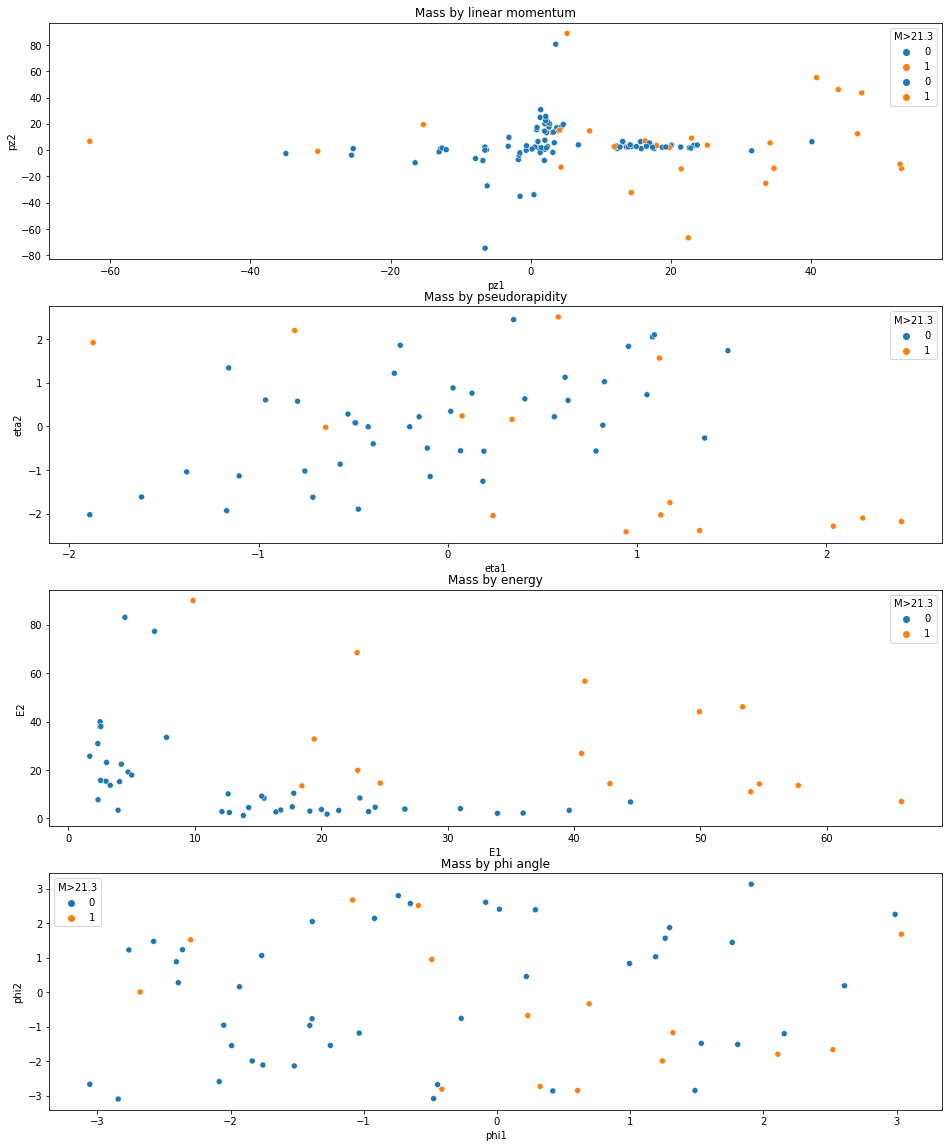

In [133]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=sample_og, x='pz1', y='pz2', hue='M>21.3')
ax[0].set_title('pz1 vs pz2')
sns.scatterplot(ax= ax[0],data=sample_og, x='pt1', y='pt2', hue='M>21.3')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=sample_og, x='eta1', y='eta2', hue='M>21.3')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=sample_og, x='E1', y='E2', hue='M>21.3')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=sample_og, x='phi1', y='phi2', hue='M>21.3')
ax[3].set_title('Mass by phi angle')

plt.show()

NameError: name 'sample_700' is not defined

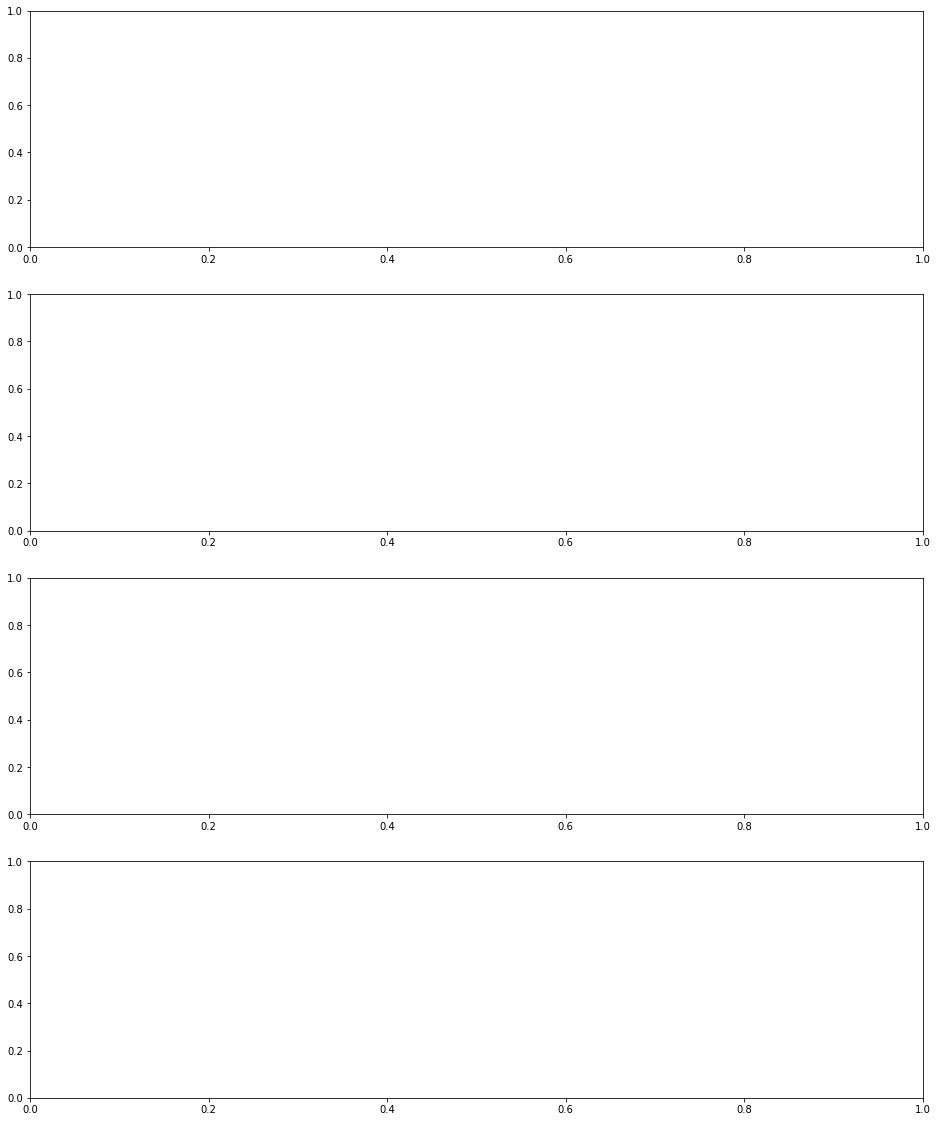

In [6]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=sample_700, x='pt1', y='pt2', hue='M>21.3')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=sample_700, x='eta1', y='eta2', hue='M>21.3')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=sample_700, x='E1', y='E2', hue='M>21.3')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=sample_700, x='phi1', y='phi2', hue='M>21.3')
ax[3].set_title('Mass by phi angle')

plt.show()

# Prep data

In [5]:
# create sample and pool, the sample has size 700
df['s1']=df['pz1']
df['s2']=df['pz2']

sample=df[df['in_biased_sample']==1]
pool=df[df['in_biased_sample']==0]


### Add extra bias

In [6]:
#add noise to s
for i in range(sample.shape[0]):
    sample['s1'].at[i]=sample['s1'][i]+np.random.normal(0,30)
    
#add noise to s
for i in range(sample.shape[0]):
    sample['s2'].at[i]=sample['s2'][i]+np.random.normal(0,30)

In [7]:
sample=sample[(sample['s1'] < 30) & (sample['s1']>-30) & (sample['s2'] < 30) & (sample['s2']>-30)]

In [323]:
sample.shape[0]

67

In [8]:
sample_og=sample
pool_og=pool

In [17]:
sample=sample_og
pool=pool_og

In [18]:
X=df.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y=df.M>21.3
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3

In [10]:
X_og=df_og.drop(columns=['M>21.3','M','Run','Event'])
y_og=df_og.M>21.3

## Visualize sample

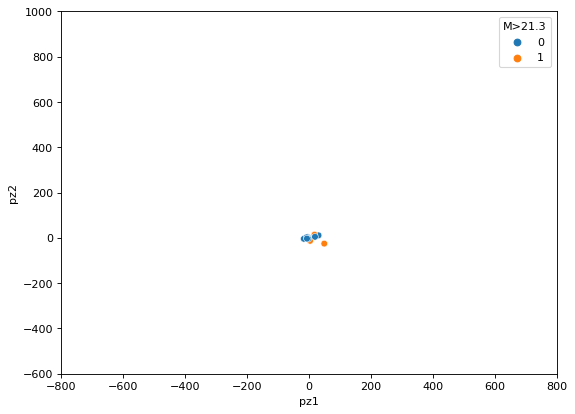

In [49]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data=sample, x='pz1', y='pz2', hue=df['M>21.3'] )
plt.xlim([ -800,800])
plt.ylim([-600, 1000])
ax = plt.gca()

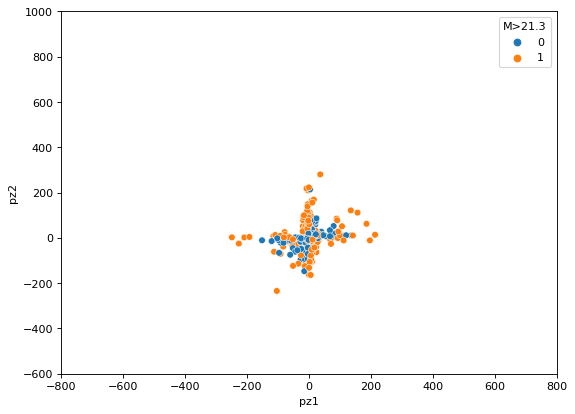

In [10]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data=pool, x='pz1', y='pz2', hue=df['M>21.3'] )
plt.xlim([ -800,800])
plt.ylim([-600, 1000])
ax = plt.gca()

# Train rf classifier

In [309]:
#train classifier on sample
rf = RandomForestClassifier()
t0 = time()
rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)
print ('training time: ', round(time()-t0, 3), 's')

training time:  0.142 s


In [310]:
#accuracy on X (whole set)
t1=time()
pred_rf = rf.predict(X.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1))
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y, pred_rf))

predicting time:  0.019 s
Accuracy: 0.67


In [311]:
pred_rf = rf.predict(X_og)
print("Accuracy:",metrics.accuracy_score(y_og, pred_rf))

Accuracy: 0.63542


In [80]:
#accuracy on sample
t1=time()
pred_rf_sample = rf.predict(X_sample)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y_sample, pred_rf_sample))


predicting time:  0.01 s
Accuracy: 1.0


## Random Forest

In [11]:
##get proximity matrix
def get_proximity_matrix(X, rf):
    
    #find proportion of indices that match between i and j
    #compute the symmetric matrix
    
    n=X.shape[0]
    tree_idxs = rf.apply(X.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1))
    proximity_matrix = np.empty(shape=(n, n))
    
    for i in range(n):
        for j in range(n):
            proximity_matrix[i,j] = np.sum(np.equal(tree_idxs[i,:], tree_idxs[j,:]))
    return proximity_matrix

In [12]:
##get maximum probabilities
def get_max_class_probabilities(X,rf):
    class_probabilities= rf.predict_proba(X.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1))
    max_class_probabilities=[0]*(len(class_probabilities))
    for i in range (len(class_probabilities)):
        max_class_probabilities[i]=max(class_probabilities[i,0],class_probabilities[i,1])
    return max_class_probabilities

In [13]:
#X=training set, pool=pool of instances to pick from
rf = RandomForestClassifier()
rf.fit(X_sample,y_sample)
#proximity_matrix=get_proximity_matrix(X+pool,rf)

RandomForestClassifier()

## AL query functions

In [14]:
def get_sum_of_proximities(i1, ys, proximity_matrix):
    proximities=[0]*len(ys)
    for i in range(len(ys)):
        proximities[i]=proximity_matrix[i,i1]
    sum_of_proximities=sum(proximities)
    return sum_of_proximities
        

In [15]:
def s_2(i, proximity_matrix):
    S_2 = get_sum_of_proximities(i, X_pool.index, proximity_matrix)*(1-max_class_probabilities[i])/(get_sum_of_proximities(i, X_sample.index, proximity_matrix)+1)
    return S_2

def uncertainty(i):
    return (1- max_class_probabilities[i])
    
def query_instance (X_sample, X_pool, rf, proximity_matrix, query_mode="s2"):
    max_class_probabilities= get_max_class_probabilities(X, rf)
    #proximity_matrix = get_proximity_matrix(X, rf)
    
    if (query_mode=="s2"):
        s_2_scores=[0]*X_pool.shape[0] 
    else: uncertainty_scores=[0]*X_pool.shape[0]
    
    for i in range(X_pool.shape[0]):
        if (query_mode=="s2"):
            s_2_scores[i]=s_2(int(X_pool.iloc[i].iloc[0]), proximity_matrix)
        else: uncertainty_scores[i]= uncertainty(int(X_pool.iloc[i].iloc[0]))
    if (query_mode=="s2"):
        queried_instance_index = int(X_pool.iloc[np.argmax(s_2_scores)].iloc[0])
    else: queried_instance_index = int(X_pool.iloc[np.argmax(uncertainty_scores)].iloc[0])
    return queried_instance_index

    #what I want to do:
    #get all values of s2 for the instances in the pool in a list
    #get the argmax, which gives the index i with the highest s2 score
    #get the instancce from the pool by using 
    #int(X_sample.iloc[0].iloc[0])

## AL algorithm

In [229]:
#def AL_algorithm(n_of_iterations, X_sample=X_sample, y_sample=y_sample, X_pool=X_pool, y_pool=y_pool, query_mode="s2"):
# initialization of AL algorithm:
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)
    print ('cp1: ', round(time()-t0, 3), 's')

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy

    #query instance and add to sample
    #if (i<10 | i%10 == 0):
    #    proximity_matrix = get_proximity_matrix(X, rf)
    
    max_class_probabilities= get_max_class_probabilities(X, rf)
    n = query_instance(X_sample, X_pool, rf, query_mode)
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy
print (accuracy)



cp1:  0.113 s


NameError: name 'query_mode' is not defined

## Compare proximity matrix at every iteration vs not

time:  8.755 s
0.64749
time:  24.967 s
0.65651
time:  41.349 s
0.66715
time:  58.783 s
0.68263
time:  75.773 s
0.69486
time:  93.109 s
0.70302
time:  110.095 s
0.71837
time:  127.646 s
0.72463
time:  146.553 s
0.73765
time:  165.013 s
0.74326
time:  182.847 s
0.73425
time:  200.619 s
0.73669
time:  218.329 s
0.73154
time:  236.699 s
0.74789
time:  254.557 s
0.75661
time:  272.533 s
0.75928
time:  290.29 s
0.77587
time:  308.779 s
0.79518
time:  328.958 s
0.81733
time:  348.01 s
0.83462
time:  366.545 s
0.82902
time:  387.205 s
0.82496
time:  405.844 s
0.82268
time:  423.826 s
0.83657
time:  443.032 s
0.83797
time:  462.102 s
0.84006
time:  481.249 s
0.85323
time:  499.994 s
0.85347
time:  519.185 s
0.85584
time:  538.828 s
0.85326
0.63273
0.64261
0.67158
0.67494
0.68858
0.69707
0.70526
0.71317
0.71742
0.7257
0.74223
0.74149
0.751
0.76659
0.76296
0.78438
0.79614
0.80365
0.82837
0.83149
0.83088
0.8301
0.83553
0.8437
0.85335
0.84384
0.8367
0.84612
0.86255
0.8618


Text(0.5, 1.0, 'Accuracy for 300 iterations with sample size 66 and pool size 1000')

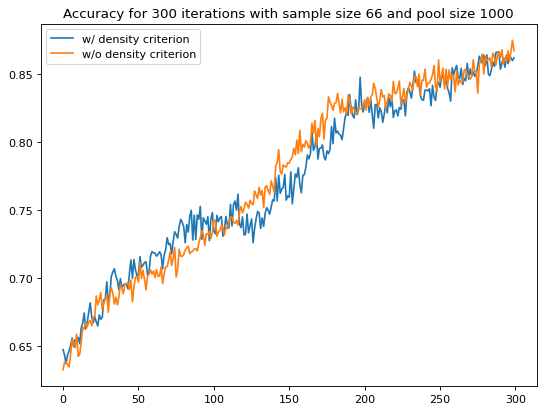

In [16]:
n_of_iterations=300

'''
#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3
'''
t0 = time()

sample_size  = sample.shape[0]
pool_size = pool.shape[0]

#run AL algorithm
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy
    #print (i,',',accuracy)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
    if (i%10 == 0):
        proximity_matrix = get_proximity_matrix(X, rf)
        print ('time: ', round(time()-t0, 3), 's')
        print (accuracy)
    n = query_instance(X_sample, X_pool, rf, proximity_matrix)
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy

pred_rf = rf.predict(X_og)

#store stuff
accuracies_with_density = accuracies
queried_instances_with_density=queried_instances
confusion_matrix_with_density=metrics.confusion_matrix(y_og, pred_rf)
final_sample_with_density=sample

#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3

#run AL algorithm with less calculations of pm
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy
    #print (i,',',accuracy)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
        #query instance and add to sample
    if (i%10 == 0):
        proximity_matrix = get_proximity_matrix(X, rf)
        print (accuracy)
    
    n = query_instance(X_sample, X_pool, rf, proximity_matrix, "uncertainty")
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy

pred_rf = rf.predict(X_og)


#store stuff
accuracies_without_density=accuracies
queried_instances_without_density=queried_instances
confusion_matrix_without_density=metrics.confusion_matrix(y_og, pred_rf)
final_sample_without_density=sample

#Plot accuracies
figure(figsize=(8, 6), dpi=80)
plt.plot(accuracies_with_density, label="w/ density criterion")
plt.plot(accuracies_without_density, label="w/o density criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Accuracy for {} iterations with sample size {} and pool size {}".format(n_of_iterations, sample_size, pool_size))

In [20]:
n_of_iterations=950

'''
#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3
'''
t0 = time()

sample_size  = sample.shape[0]
pool_size = pool.shape[0]

#run AL algorithm
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy
    #print (i,',',accuracy)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
    if (i%10 == 0):
        proximity_matrix = get_proximity_matrix(X, rf)
        print ('time: ', round(time()-t0, 3), 's')
        print (accuracy)
    n = query_instance(X_sample, X_pool, rf, proximity_matrix)
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy

pred_rf = rf.predict(X_og)

#store stuff
accuracies_with_density = accuracies
queried_instances_with_density=queried_instances
confusion_matrix_with_density=metrics.confusion_matrix(y_og, pred_rf)
final_sample_with_density=sample

#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3

#run AL algorithm with less calculations of pm
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=n_of_iterations
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)

    #store accuracy
    pred_rf = rf.predict(X_og)
    accuracy = metrics.accuracy_score(y_og, pred_rf)
    accuracies[i] = accuracy
    #print (i,',',accuracy)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
        #query instance and add to sample
    if (i%10 == 0):
        proximity_matrix = get_proximity_matrix(X, rf)
        print (accuracy)
    
    n = query_instance(X_sample, X_pool, rf, proximity_matrix, "uncertainty")
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final accuracy
pred_rf = rf.predict(X_og)
accuracy = metrics.accuracy_score(y_og, pred_rf)
accuracies[n_of_iterations-1] = accuracy

pred_rf = rf.predict(X_og)


#store stuff
accuracies_without_density=accuracies
queried_instances_without_density=queried_instances
confusion_matrix_without_density=metrics.confusion_matrix(y_og, pred_rf)
final_sample_without_density=sample

#Plot accuracies
figure(figsize=(8, 6), dpi=80)
plt.plot(accuracies_with_density, label="w/ density criterion")
plt.plot(accuracies_without_density, label="w/o density criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Accuracy for {} iterations with sample size {} and pool size {}".format(n_of_iterations, sample_size, pool_size))

time:  9.358 s
0.76305
time:  28.735 s
0.75125
time:  47.47 s
0.77633
time:  65.194 s
0.79196
time:  83.091 s
0.79756
time:  101.365 s
0.79735
time:  120.05 s
0.80676
time:  138.796 s
0.80692
time:  159.784 s
0.80287
time:  180.326 s
0.80886
time:  202.014 s
0.81977
time:  222.659 s
0.81212
time:  243.387 s
0.82627
time:  265.274 s
0.83112
time:  287.315 s
0.84029
time:  311.792 s
0.84761
time:  334.399 s
0.85463
time:  357.375 s
0.85521
time:  378.719 s
0.8738
time:  404.813 s
0.87419
time:  429.558 s
0.87892
time:  452.818 s
0.87828
time:  475.343 s
0.87915
time:  496.431 s
0.88591
time:  517.242 s
0.88468
time:  540.616 s
0.88772
time:  562.424 s
0.8843
time:  584.142 s
0.88179
time:  606.466 s
0.88686
time:  629.348 s
0.88977
time:  651.791 s
0.88356
time:  673.467 s
0.88584
time:  695.017 s
0.88714
time:  717.676 s
0.88796
time:  739.044 s
0.89639
time:  761.025 s
0.89601
time:  783.428 s
0.88031
time:  806.9 s
0.88887
time:  829.061 s
0.88766
time:  851.429 s
0.88933
time:  873.6

ValueError: attempt to get argmax of an empty sequence